In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torchvision.transforms as T
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from dataloaders import PackageTrainDataset, PackageTestDataset
from models import MyModel
from metrics import MCE, OE, AC

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
VALIDATION_RATIO = 0.08
RANDOM_SEED = 42
X, Y, W, H = 560, 150, 300, 330
ROI = (X, Y, X + W, Y + H)  # (left, upper, right, lower)
NUM_POINTS = 32768  # 32
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN_MEMORY = True
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 100
LAMBDA = 3.6

train_dir = './data/Train/'
train_label_dir = train_dir + 'Public train.csv'
train_rgb_dir = train_dir + 'rgb/'
train_depth_dir = train_dir + 'depth/'
train_ply_dir = train_dir + 'ply/'

test_dir = './data/Test/'
test_rgb_dir = test_dir + 'rgb/'
test_depth_dir = test_dir + 'depth/'
test_ply_dir = test_dir + 'ply/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv(train_label_dir)
train_df, val_df = train_test_split(
    df,
    test_size=VALIDATION_RATIO,
    random_state=RANDOM_SEED,
    shuffle=True
)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 230
Validation set size: 20


In [5]:
rgb_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

depth_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

In [6]:
train_set = PackageTrainDataset(
    df=train_df, 
    rgb_dir=train_rgb_dir,
    depth_dir=train_depth_dir,
    ply_dir=train_ply_dir,
    roi=ROI,
    num_points=NUM_POINTS,
    rgb_transform=rgb_transforms,
    depth_transform=depth_transforms,
    ply_transform=True
)

val_set = PackageTrainDataset(
    df=val_df, 
    rgb_dir=train_rgb_dir,
    depth_dir=train_depth_dir,
    ply_dir=train_ply_dir,
    roi=ROI,
    num_points=NUM_POINTS,
    rgb_transform=rgb_transforms,
    depth_transform=depth_transforms,
    ply_transform=True
)
test_set = PackageTestDataset(
    rgb_dir=test_rgb_dir,
    depth_dir=test_depth_dir,
    ply_dir=test_ply_dir,
    roi=ROI,
    num_points=NUM_POINTS,
    rgb_transform=rgb_transforms,
    depth_transform=depth_transforms,
    ply_transform=True
)

In [7]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)


In [5]:
model = MyModel(weights=None).to(device)
model = DataParallel(model)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
coordinate_criterion = torch.nn.MSELoss()
angle_criterion = torch.nn.CosineEmbeddingLoss()

In [10]:
history = {"train_loss": [], "val_loss": [], "val_mce": [], "val_oe": [], "val_ac": [], "lr": []}

In [11]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        images, points, labels = batch['rgb_depths'].to(device), batch['xyz_rgbs'].to(device), batch['labels'].to(device)
        label_coordinates, label_angles = labels[:,:3], labels[:,3:]
        y = torch.ones(label_angles.size(0), device=device)
        
        optimizer.zero_grad()
        outputs = model(images, points)
        output_coordinates, output_angles = outputs[:,:3], outputs[:,3:]
        coordinate_loss = coordinate_criterion(output_coordinates, label_coordinates)
        angle_loss = angle_criterion(output_angles, label_angles, y)
        loss = coordinate_loss * LAMBDA + angle_loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    total_val_mce = 0
    total_val_oe = 0
    with torch.no_grad():
        for batch in val_loader:
            images, points, labels = batch['rgb_depths'].to(device), batch['xyz_rgbs'].to(device), batch['labels'].to(device)
            label_coordinates, label_angles = labels[:,:3], labels[:,3:]
            y = torch.ones(label_angles.size(0), device=device)

            outputs = model(images, points)
            output_coordinates, output_angles = outputs[:,:3], outputs[:,3:]
            coordinate_loss = coordinate_criterion(output_coordinates, label_coordinates)
            angle_loss = angle_criterion(output_angles, label_angles, y)
            loss = coordinate_loss * LAMBDA + angle_loss
            mce = MCE(output_coordinates, label_coordinates)
            oe = OE(output_angles, label_angles)

            total_val_loss += loss.item()
            total_val_mce += mce.item()
            total_val_oe += oe.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_mce = total_val_mce / len(val_loader)
    avg_val_oe = total_val_oe / len(val_loader)
    val_ac = AC(avg_val_mce, avg_val_oe)
    history['val_loss'].append(avg_val_loss)
    history['val_mce'].append(avg_val_mce)
    history['val_oe'].append(avg_val_oe)
    history['val_ac'].append(val_ac)

    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Training Loss: {avg_train_loss:.5f} | Validation Loss: {avg_val_loss:.5f} | MCE: {avg_val_mce:.5f} | OE: {avg_val_oe:.5f} | AC: {val_ac:.5f} | Learning Rate: {current_lr:.1e}")

Epoch [1/3] | Training Loss: 5.15048 | Validation Loss: 2.64285 | MCE: 1.00000 | OE: 1.00000 | AC: 0.00000 | Learning Rate: 1.0e-04
Epoch [2/3] | Training Loss: 3.96681 | Validation Loss: 2.22361 | MCE: 1.00000 | OE: 0.99926 | AC: 0.00022 | Learning Rate: 1.0e-04
Epoch [3/3] | Training Loss: 3.13724 | Validation Loss: 18.58122 | MCE: 1.00000 | OE: 1.00000 | AC: 0.00000 | Learning Rate: 1.0e-04


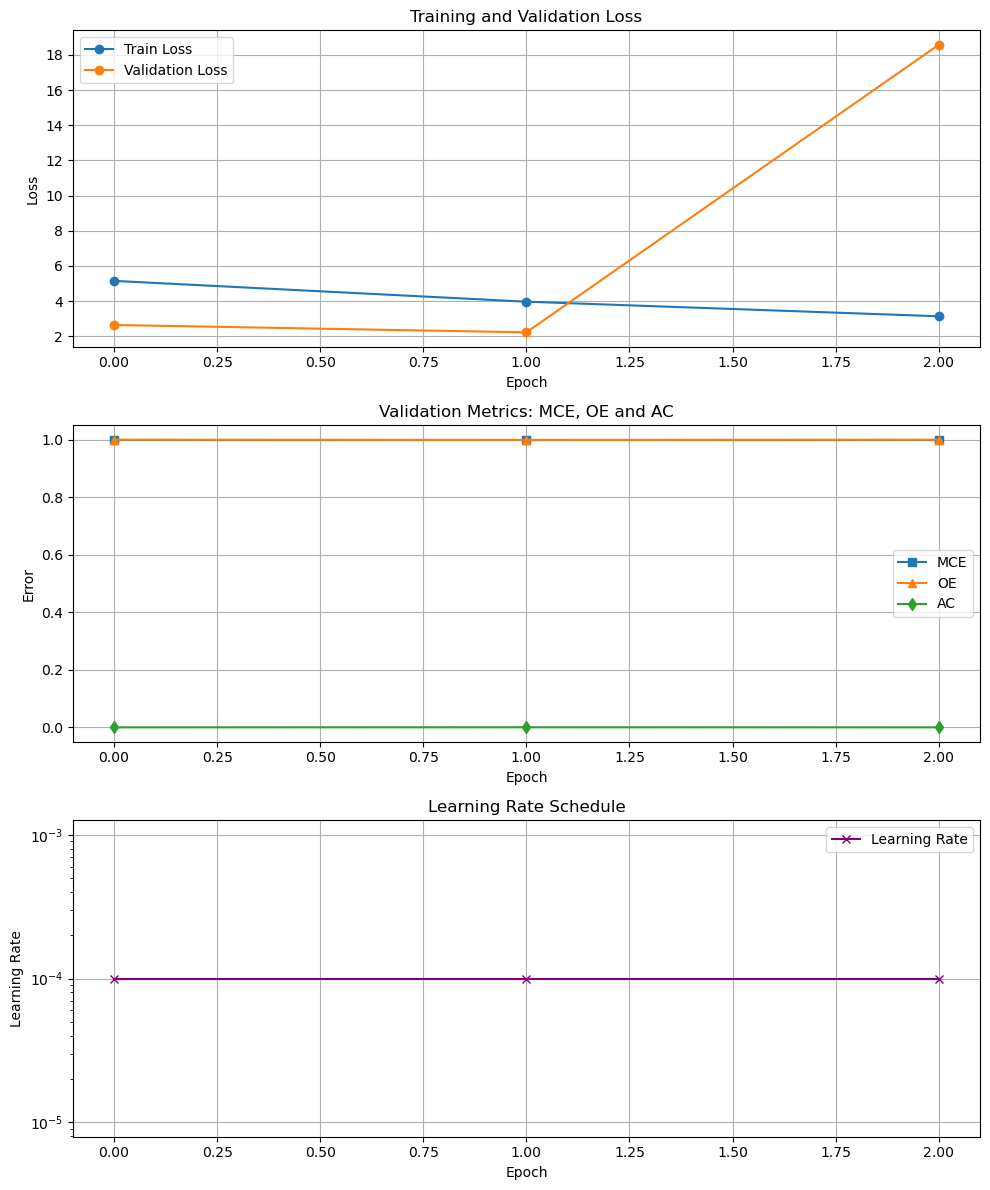

In [12]:
# Create a figure with 3 subplots (stacked vertically)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Training and Validation Loss
axes[0].plot(history["train_loss"], label="Train Loss", marker='o')
axes[0].plot(history["val_loss"], label="Validation Loss", marker='o')
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Validation MCE and OE
axes[1].plot(history["val_mce"], label="MCE", marker='s')
axes[1].plot(history["val_oe"], label="OE", marker='^')
axes[1].plot(history["val_ac"], label="AC", marker='d')
axes[1].set_title("Validation Metrics: MCE, OE and AC")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Error")
axes[1].legend()
axes[1].grid(True)

# Plot 3: Learning Rate
axes[2].plot(history["lr"], label="Learning Rate", color='purple', marker='x')
axes[2].set_title("Learning Rate Schedule")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_yscale("log")  # Learning rate often benefits from log scale
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [13]:
results = []
with torch.no_grad():
    for batch in test_loader:
        images, points = batch['rgb_depths'].to(device), batch['xyz_rgbs'].to(device)
        outputs = model(images, points)
        coordinates, angles = outputs[:,:3], outputs[:,3:]
        normalized_angles = angles / torch.norm(angles, dim=1, keepdim=True)
        names = batch['names']

        for i, name in enumerate(names):
            row = {
                'image_filename': name,
                'x': coordinates[i, 0].item(),
                'y': coordinates[i, 1].item(),
                'z': coordinates[i, 2].item(),
                'Rx': normalized_angles[i, 0].item(),
                'Ry': normalized_angles[i, 1].item(),
                'Rz': normalized_angles[i, 2].item(),
            }
            results.append(row)

df = pd.DataFrame(results)
df = df.sort_values(by='image_filename').reset_index(drop=True)
df.to_csv('Submission_3D.csv', index=False)